# Toy example

This notebook shows how to use the toolkit for explainable AI and fairness. The toy example used is a binary classification trained using lightGBM.

The toolkit uses part, if not all, of the following open-source Python packages:
- `pdpbox`
- `shap`
- `aif360`

The toolkit is model agnostic; the selected functions of the packages should work for models trained by most algorithms.

In [1]:
import json

import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from pdpbox import info_plots
from aif360.metrics.classification_metric import ClassificationMetric

from utils import lgb_roc_auc_score, plot_roc_curve, plot_pr_curve

%matplotlib inline
%load_ext autoreload
%autoreload 2

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [2]:
from xai_fairness.toolkit import (
    pdp_plot, actual_plot, target_plot, pdp_interact_plot, 
    prepare_dataset, compute_fairness_metrics, color_red,
)

## Load data, category_map

In [3]:
NUMERIC_FEATS = [
    'Age',
    'Capital Gain',
    'Capital Loss',
    'Hours per week',
]

CATEGORICAL_FEATS = [
    'Workclass',
    'Education',
    'Marital Status',
    'Occupation',
    'Relationship',
    'Race',
    'Sex',
    'Country',
]

TARGET = "Target"
TARGET_NAMES = ['<=50K', '>50K']

CATEGORY_MAP = json.load(open("input/category_map.txt"))

In [4]:
data = pd.read_csv("input/adult.csv")
data = data[CATEGORICAL_FEATS + NUMERIC_FEATS + [TARGET]]
print(data.shape)
data.head()

(32561, 13)


,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Country,Age,Capital Gain,Capital Loss,Hours per week,Target
0,7,1,1,1,1,4,1,9,39,2174,0,40,0
1,6,1,0,8,0,4,1,9,50,0,0,13,0
2,4,4,2,2,1,4,1,9,38,0,0,40,0
3,4,3,0,2,0,2,1,9,53,0,0,40,0
4,4,1,0,5,5,2,0,6,28,0,0,40,0


In [5]:
# Split train and validation data
raw_train, raw_val = train_test_split(data, random_state=1)
y_train = raw_train[TARGET].values
y_val = raw_val[TARGET].values

## Preprocess

In [6]:
# Apply OHE to categorical features
categories = []
for f in CATEGORICAL_FEATS:
    categories.append(list(range(len(CATEGORY_MAP[f]))))
    
ohe = OneHotEncoder(categories=categories, sparse=False)
ohe_train = ohe.fit_transform(raw_train[CATEGORICAL_FEATS])
ohe_val = ohe.transform(raw_val[CATEGORICAL_FEATS])

In [7]:
# Standardise numeric features to [-1, 1]
minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train = minmax_scaler.fit_transform(raw_train[NUMERIC_FEATS])
scaled_val = minmax_scaler.fit_transform(raw_val[NUMERIC_FEATS])

In [8]:
# Concatenate data and set it as pandas.DataFrame.
# Required in order to use PDP and SHAP
OHE_CAT_FEATS = []
for f in CATEGORICAL_FEATS:
    OHE_CAT_FEATS.extend(CATEGORY_MAP[f])

FEATURES = OHE_CAT_FEATS + NUMERIC_FEATS
    
x_train = pd.DataFrame(np.c_[ohe_train, scaled_train].astype(np.float32, copy=False),
                       columns=FEATURES)
x_val = pd.DataFrame(np.c_[ohe_val, scaled_val].astype(np.float32, copy=False),
                       columns=FEATURES)

## Train model

In [9]:
# Train
clf = lgb.LGBMClassifier(
    learning_rate=0.1,
    num_leaves=20,
    n_estimators=100,
)

clf.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)],
    eval_metric=lgb_roc_auc_score,
    verbose=False,
)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=20, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

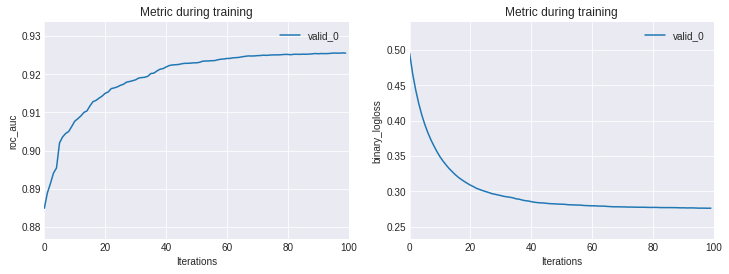

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
lgb.plot_metric(clf, "roc_auc", ax=axs[0])
lgb.plot_metric(clf, "binary_logloss", ax=axs[1])
plt.show()

# Entry point of explainability tools

- We have written some wrapper functions in `utils.py` to plot partial dependence plots.
- We also demonstrate how to use `SHAP` in our toy example, which one can easily adapt it for their own use cases. SHAP is well maintained and easy to use. User can refer to the SHAP documentation for more details. 
- The requirements for using the toolkit are
  - sample data
  - model

## Sample data

This is to reduce the computation time. The more data is used, the longer the tools will need to process.

In [11]:
np.random.seed(0)
idx = np.random.choice(np.arange(len(x_train)), size=3000, replace=False)

x_sample = x_train.iloc[idx]

sample = x_sample.copy()
sample[TARGET] = y_train[idx]

# Partial Dependence Plots

### 1D Partial Dependence Plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


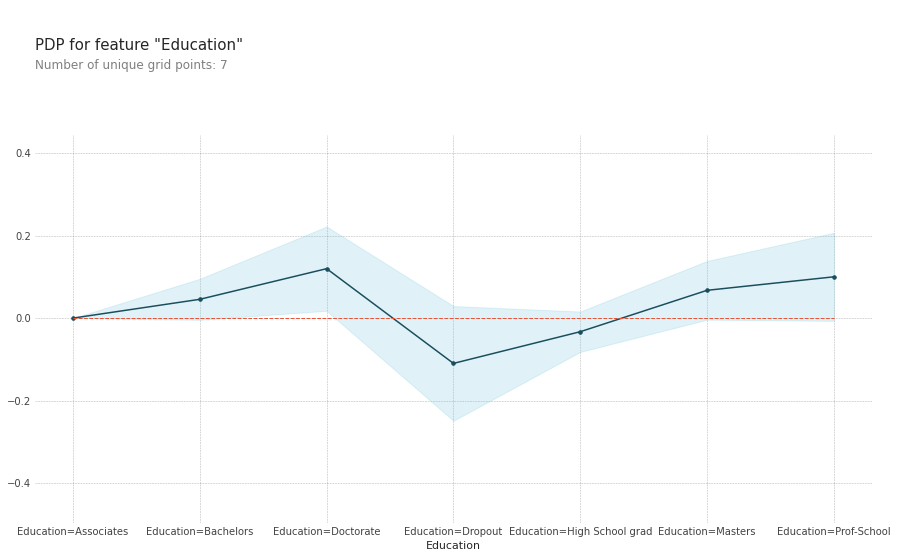

In [12]:
# One-hot encoded feature
feature_name = "Education"
feature = CATEGORY_MAP[feature_name]

fig = pdp_plot(clf, x_sample, FEATURES, feature, feature_name)
# fig, _ = actual_plot(clf, x_sample, feature, feature_name)
# fig, _ = target_plot(sample, feature, feature_name, TARGET)

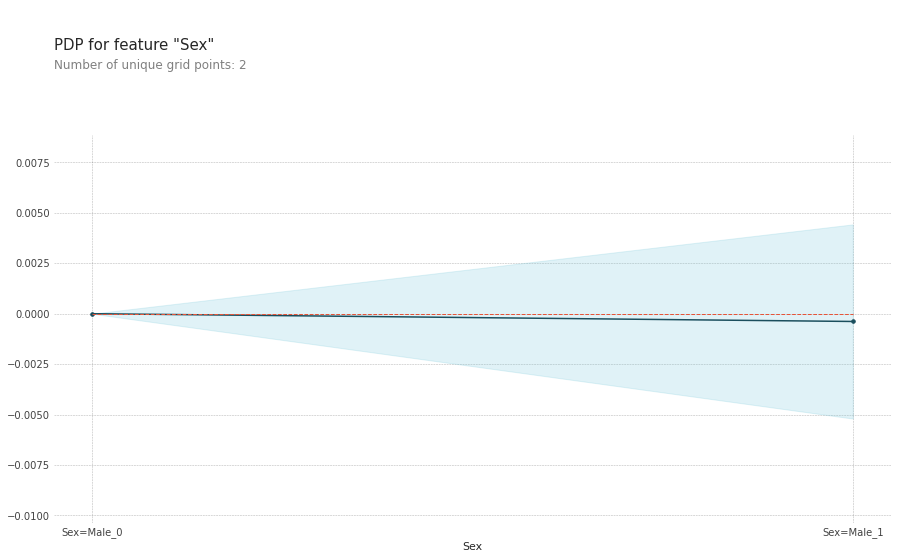

In [13]:
# Binary feature
feature_name = "Sex"
feature = "Sex=Male"

fig = pdp_plot(clf, x_sample, FEATURES, feature, feature_name)
# fig, _ = actual_plot(clf, x_sample, feature, feature_name, show_percentile=True)
# fig, _ = target_plot(sample, feature, feature_name, TARGET)

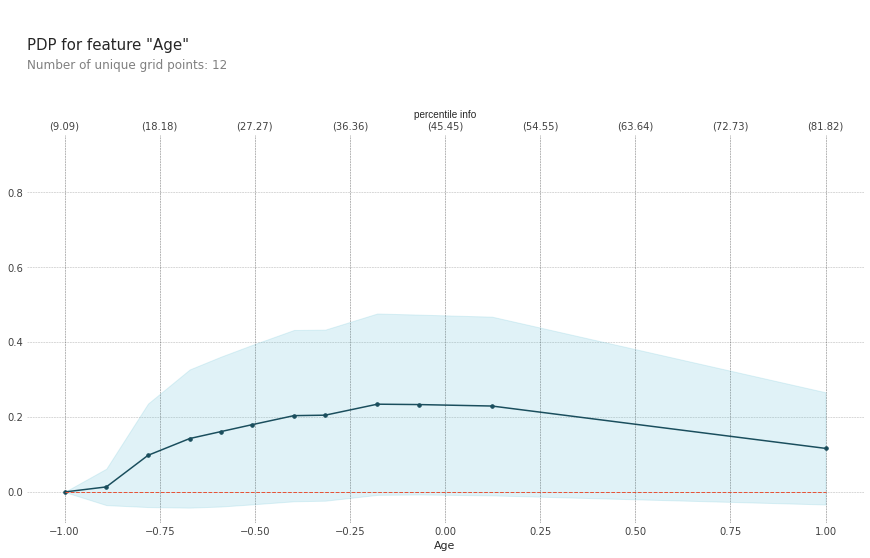

In [14]:
# Continuous feature
feature_name = "Age"
feature = feature_name

fig = pdp_plot(clf, x_sample, FEATURES, feature, feature_name, num_grid_points=12, show_percentile=True)
# fig, _ = actual_plot(clf, x_sample, feature, feature_name, num_grid_points=12, show_percentile=True)
# fig, _ = target_plot(sample, feature, feature_name, TARGET, num_grid_points=12, show_percentile=True)

### 2D Partial Dependence Plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


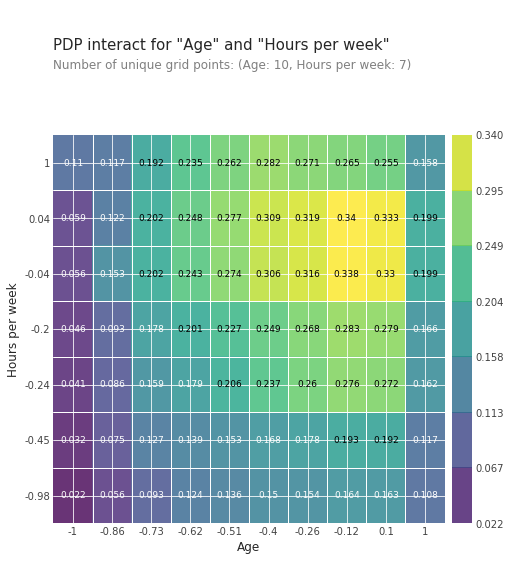

In [15]:
feature1 = 'Age'
feature2 = 'Hours per week'

fig = pdp_interact_plot(clf, x_sample, FEATURES, feature1, feature2)

In [16]:
# fig, axes, summary_df = info_plots.target_plot_interact(
#     sample, [feature1, feature2], [feature1, feature2], TARGET)

# fig, axes, summary_df = info_plots.actual_plot_interact(
#     clf, x_sample, [feature1, feature2], [feature1, feature2])

# SHAP

The SHAP package has explainers for every type of model:
- `shap.TreeExplainer` works with tree-based models (XGBoost/LightGBM/CatBoost/scikit-learn/pyspark models)
- `shap.DeepExplainer` works with Deep Learning models (TensorFlow/Keras models) 
- `shap.KernelExplainer` works with all models, though it is slower than other explainers and it provides only approximation rather than exact Shapley values.

In [17]:
# LightGBM is used in our toy example, hence TreeExplainer
explainer = shap.TreeExplainer(clf)

### Explain individual instance

In [18]:
row = 2185
instance = x_sample.iloc[row: row + 1]

In [19]:
# Predicted probabilities
clf.predict_proba(instance)[0]

array([0.9530876, 0.0469124])

In [20]:
shap_values = explainer.shap_values(instance)[1]
base_value = explainer.expected_value[1]

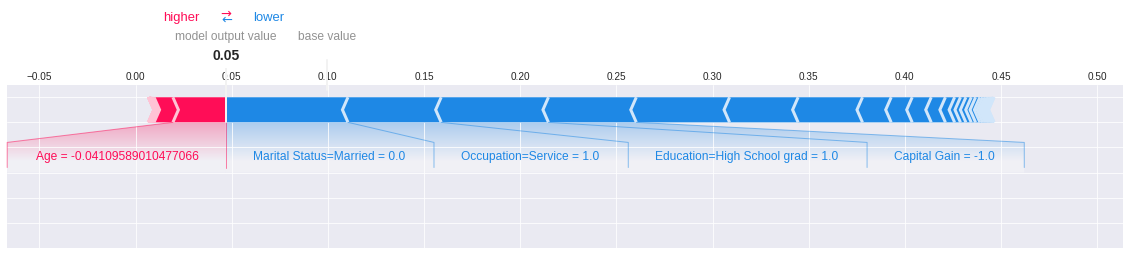

In [21]:
# Visualize the SHAP values using force_plot
shap.force_plot(base_value, shap_values, instance, link='logit', matplotlib=True)

### Summary plot

In [22]:
# Calculate SHAP values
shap_values = explainer.shap_values(x_sample)[1]

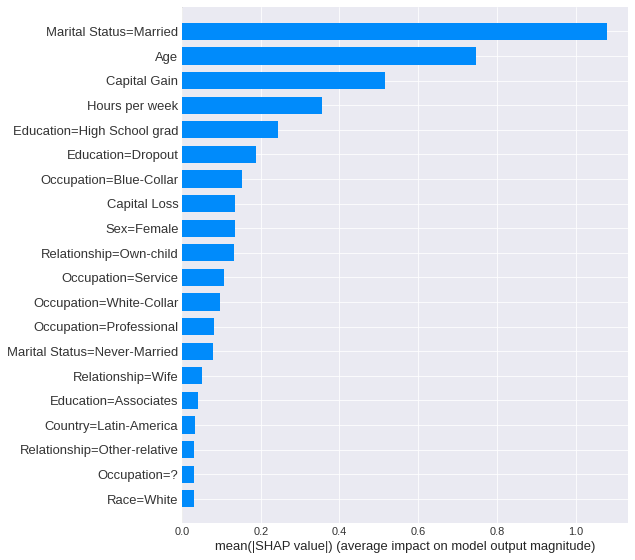

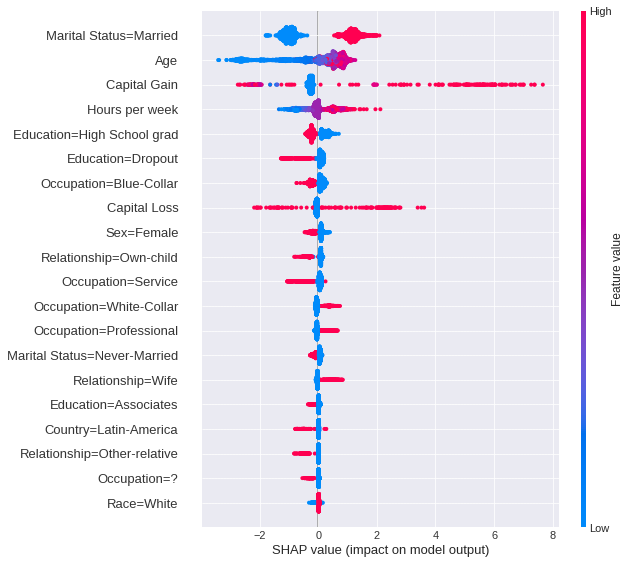

In [23]:
# summarize the effects of all features
shap.summary_plot(shap_values, plot_type="bar", feature_names=FEATURES)
shap.summary_plot(shap_values, x_sample, feature_names=FEATURES)

### SHAP Dependence Contribution Plots

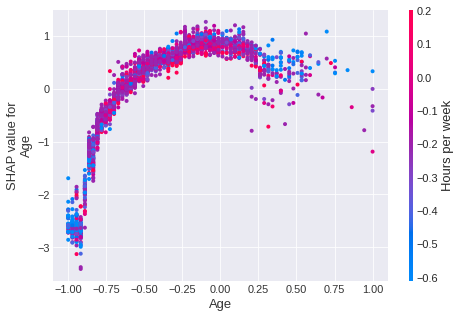

In [25]:
feature = "Age"
interaction_feature = "Hours per week"
shap.dependence_plot(feature, shap_values, x_sample, interaction_index=interaction_feature)

If you don't supply an argument for `interaction_index`, SHAP uses some logic to pick one that may be interesting.

# Entry point for fairness metrics

- In this toy example, the favourable label is '>50K' which corresponds to 1
- Suppose that race is the protected column, and that race=white is the privileged group and the rest forms the unprivileged group. 

**Ensure that the data is not one-hot encoded, so that the helpers can find the privileged and unprivileged groups from the data provided by you.**

In [26]:
threshold = 0.2

In [27]:
BIAS_INFO = {
    'favorable_label': 1,
    'unfavorable_label': 0,
    'protected_columns': [
        'Race=Amer-Indian-Eskimo', 'Race=Asian-Pac-Islander',
        'Race=Black', 'Race=Other', 'Race=White']
}

PRIVILEGED_INFO = {
    'unprivileged_groups': [{'Race=White': 0}],
    'privileged_groups': [{'Race=White': 1}]
}

In [28]:
# Original model performance
y_val_prob = clf.predict_proba(x_val)[:, 1]
y_val_pred = (y_val_prob > 0.5).astype(int)

print(f"Model accuracy = {metrics.accuracy_score(y_val, y_val_pred):.4f}")
print("Weighted Average Precision = {:.4f}".format(metrics.precision_score(y_val, y_val_pred, average="weighted")))
print("Weighted Average Recall = {:.4f}".format(metrics.recall_score(y_val, y_val_pred, average="weighted")), "\n")
print(metrics.classification_report(y_val, y_val_pred, digits=4))

Model accuracy = 0.8779
Weighted Average Precision = 0.8738
Weighted Average Recall = 0.8779 

              precision    recall  f1-score   support

           0     0.9062    0.9396    0.9226      6303
           1     0.7628    0.6665    0.7114      1838

    accuracy                         0.8779      8141
   macro avg     0.8345    0.8030    0.8170      8141
weighted avg     0.8738    0.8779    0.8749      8141



In [29]:
# Prepare val dataset
grdtruth_val = prepare_dataset(x_val, y_val, **BIAS_INFO, **PRIVILEGED_INFO)
predicted_val = prepare_dataset(x_val, y_val_pred, **BIAS_INFO, **PRIVILEGED_INFO)

In [30]:
# Compute fairness
clf_metric = ClassificationMetric(grdtruth_val, predicted_val, **PRIVILEGED_INFO)
fmeasures = compute_fairness_metrics(clf_metric)
fmeasures["Fair?"] = fmeasures["Ratio"].apply(lambda x: "Yes" if np.abs(x - 1) < threshold else "No")

print(f"Fairness is when ratio is between {1-threshold} and {1+threshold}")
display(fmeasures.iloc[:3]
        .style.applymap(color_red, subset=["Fair?"]))

Fairness is when ratio is between 0.8 and 1.2


,Metric,Criterion,All,Unprivileged,Privileged,Ratio,Fair?
0,Statistical parity,Independence,0.197273,0.107926,0.212509,0.507865,No
1,Equal opportunity,Separation,0.333515,0.413174,0.325554,1.269142,No
2,Predictive parity,Sufficiency,0.762765,0.765625,0.762517,1.004076,Yes


# Debiasing: calibrated equal odds

We demonstrate a form of debiasing here using calibrated equal odds.
- Optimizes for TPR/FPR difference and improves calibration.
- Requires only model predictions as input, so no need to retrain anything
- But no option to tweak fairness-accuracy tradeoff

In [31]:
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

In [32]:
# Prepare train dataset
y_train_prob = clf.predict_proba(x_train)[:, 1]
y_train_pred = (y_train_prob > 0.5).astype(int)

grdtruth_train = prepare_dataset(x_train, y_train, **BIAS_INFO, **PRIVILEGED_INFO)
predicted_train = prepare_dataset(x_train, y_train_pred, **BIAS_INFO, **PRIVILEGED_INFO)

In [33]:
# Train
calibrator = CalibratedEqOddsPostprocessing(**PRIVILEGED_INFO, seed=0)

calibrator.fit(grdtruth_train, predicted_train)

# Predict using calibrator
adj_pred_val = calibrator.predict(predicted_val)

In [34]:
y_val_adj = adj_pred_val.labels

# Compute accuracy after debiasing
print(f"Model accuracy = {metrics.accuracy_score(y_val, y_val_adj):.4f}")
print("Weighted Average Precision = {:.4f}".format(metrics.precision_score(y_val, y_val_adj, average="weighted")))
print("Weighted Average Recall = {:.4f}".format(metrics.recall_score(y_val, y_val_adj, average="weighted")), "\n")
print(metrics.classification_report(y_val, y_val_adj, digits=4))

Model accuracy = 0.8613
Weighted Average Precision = 0.8542
Weighted Average Recall = 0.8613 

              precision    recall  f1-score   support

           0     0.8813    0.9486    0.9137      6303
           1     0.7612    0.5620    0.6466      1838

    accuracy                         0.8613      8141
   macro avg     0.8213    0.7553    0.7802      8141
weighted avg     0.8542    0.8613    0.8534      8141



In [35]:
# Compute fairness
clf_metric = ClassificationMetric(grdtruth_val, adj_pred_val, **PRIVILEGED_INFO)
fmeasures = compute_fairness_metrics(clf_metric)
fmeasures["Fair?"] = fmeasures["Ratio"].apply(lambda x: "Yes" if np.abs(x - 1) < threshold else "No")

print(f"Fairness is when ratio is between {1-threshold} and {1+threshold}")
display(fmeasures.iloc[:3]
        .style.applymap(color_red, subset=["Fair?"]))

Fairness is when ratio is between 0.8 and 1.2


,Metric,Criterion,All,Unprivileged,Privileged,Ratio,Fair?
0,Statistical parity,Independence,0.166687,0.107926,0.176707,0.610760,No
1,Equal opportunity,Separation,0.437976,0.413174,0.440455,0.938061,Yes
2,Predictive parity,Sufficiency,0.761238,0.765625,0.760781,1.006367,Yes


# Debiasing: adversarial debiasing

In [36]:
import tensorflow as tf
from aif360.algorithms.inprocessing import AdversarialDebiasing

In [37]:
# Train

model_params = {
    'classifier_num_hidden_units':200, 
    'num_epochs':20,
    'batch_size':128,
    'adversary_loss_weight':0.1,
    'debias':True,
    'seed':1234,
}

with tf.Session() as sess:
    debias_clf = AdversarialDebiasing(scope_name='debiased_classifier', sess=sess, **PRIVILEGED_INFO, **model_params)
    debias_clf.fit(grdtruth_train)
    
    # Predict using debiased classifier
    adj_pred_val = debias_clf.predict(grdtruth_val)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





epoch 0; iter: 0; batch classifier loss: 0.690589; batch adversarial loss: 0.738888
epoch 1; iter: 0; batch classifier loss: 0.325732; batch adversarial loss: 0.686461
epoch 2; iter: 0; batch classifier loss: 0.388129; batch adversarial loss: 0.612577
epoch 3; iter: 0; batch classifier loss: 0.447490; batch adversarial loss: 0.535058
epoch 4; iter: 0; batch classifier loss: 0.369317; batch adversarial loss: 0.467046

In [38]:
y_val_adj = adj_pred_val.labels

# Compute accuracy after debiasing
print(f"Model accuracy = {metrics.accuracy_score(y_val, y_val_adj):.4f}")
print("Weighted Average Precision = {:.4f}".format(metrics.precision_score(y_val, y_val_adj, average="weighted")))
print("Weighted Average Recall = {:.4f}".format(metrics.recall_score(y_val, y_val_adj, average="weighted")), "\n")
print(metrics.classification_report(y_val, y_val_adj, digits=4))

Model accuracy = 0.8498
Weighted Average Precision = 0.8420
Weighted Average Recall = 0.8498 

              precision    recall  f1-score   support

           0     0.8808    0.9321    0.9057      6303
           1     0.7090    0.5675    0.6304      1838

    accuracy                         0.8498      8141
   macro avg     0.7949    0.7498    0.7681      8141
weighted avg     0.8420    0.8498    0.8436      8141



In [39]:
# Compute fairness
clf_metric = ClassificationMetric(grdtruth_val, adj_pred_val, **PRIVILEGED_INFO)
fmeasures = compute_fairness_metrics(clf_metric)
fmeasures["Fair?"] = fmeasures["Ratio"].apply(lambda x: "Yes" if np.abs(x - 1) < threshold else "No")

print(f"Fairness is when ratio is between {1-threshold} and {1+threshold}")
display(fmeasures.iloc[:3]
        .style.applymap(color_red, subset=["Fair?"]))

Fairness is when ratio is between 0.8 and 1.2


,Metric,Criterion,All,Unprivileged,Privileged,Ratio,Fair?
0,Statistical parity,Independence,0.180690,0.241990,0.170237,1.421486,No
1,Equal opportunity,Separation,0.432535,0.167665,0.459007,0.365277,No
2,Predictive parity,Sufficiency,0.709041,0.484321,0.763514,0.634331,No


In [40]:
sess.close()
tf.reset_default_graph()